# Облегченная нейронная сеть, настроенная на распознвание цифр

Добавляем нужные библиотеки

In [1]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
import numpy as np

import time
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset

Скачиваем и/или инцилизруем наши данные

In [2]:
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

Покажем, как выглядит датасет

5


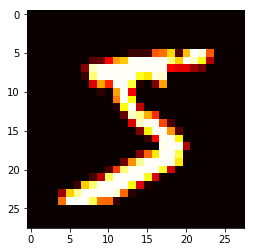

In [3]:
plt.imshow(X_train[0,0], cmap=plt.cm.hot)
print y_train[0]

## Нейросеть

In [4]:
input_X = T.tensor4('Input')
target_y = T.vector('Target', dtype='int32')

### Архетиктура сети

In [5]:
#Входной слой сети
input_layer  = lasagne.layers.InputLayer(shape=(None,1,28,28), input_var=input_X, name = "Input")
#Внутренний слой сети
dense_layer  = lasagne.layers.DenseLayer(input_layer,num_units=100, nonlinearity=sigmoid, name = "Dense")
#Выходной слой сети
output_layer = lasagne.layers.DenseLayer(dense_layer,num_units = 10, nonlinearity=softmax, name = "Output")

In [6]:
#предсказание нейронной сети
y_predicted = lasagne.layers.get_output(output_layer)
#Веса нейронной сети
all_weights = lasagne.layers.get_all_params(output_layer)

In [7]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [8]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

#функция, которая выдает прогноз
pred_fun = theano.function([input_X], y_predicted)

## Процесс обучения

In [9]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [10]:
num_epochs = 15 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 15 took 1.851s
  training loss (in-iteration):		0.260285
  train accuracy:		92.26 %
  validation accuracy:		96.09 %
Epoch 2 of 15 took 1.958s
  training loss (in-iteration):		0.113167
  train accuracy:		96.64 %
  validation accuracy:		96.61 %
Epoch 3 of 15 took 1.974s
  training loss (in-iteration):		0.078703
  train accuracy:		97.66 %
  validation accuracy:		96.67 %
Epoch 4 of 15 took 1.851s
  training loss (in-iteration):		0.058759
  train accuracy:		98.26 %
  validation accuracy:		97.11 %
Epoch 5 of 15 took 1.849s
  training loss (in-iteration):		0.046235
  train accuracy:		98.62 %
  validation accuracy:		97.05 %
Epoch 6 of 15 took 1.975s
  training loss (in-iteration):		0.035112
  train accuracy:		98.93 %
  validation accuracy:		97.02 %
Epoch 7 of 15 took 2.418s
  training loss (in-iteration):		0.027560
  train accuracy:		99.22 %
  validation accuracy:		96.85 %
Epoch 8 of 15 took 1.915s
  training loss (in-iteration):		0.021428
  train accuracy:		99.42 %
  validation acc

In [11]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))


Final results:
  test accuracy:		97.36 %


In [12]:
X_test[[0]].shape

(1, 1, 28, 28)

7


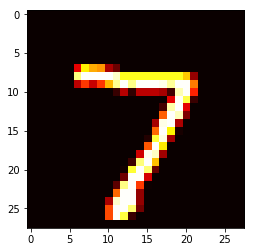

In [13]:
plt.imshow(X_test[0,0], cmap=plt.cm.hot)
print np.argmax(pred_fun(X_test[[0]]))